In [1]:
from axikernels.core.handlers import element_output
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = element_output.ElementOutput(path_to_element_output='data/EXAMPLE_ELEMENT/output/elements')

In [3]:
data.element_groups_info['mantle']['elements']

{'horizontal_range': [0, 3.141592653589793],
 'vertical_range': ['3400e3', '6371e3']}

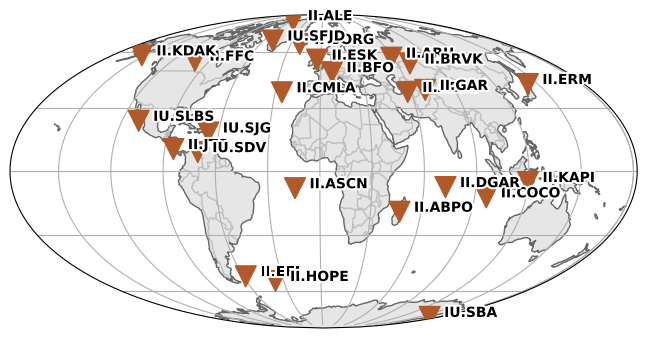

In [4]:
%matplotlib inline
inv = data.create_inventory(path_to_station_file='data/EXAMPLE/input/GSN_small.txt')
inv.plot()
plt.show()

In [5]:
points = np.array([6371000, 30, 0])
wavedata = data.load_data(points, channels=['UZ'])

Loading and interpolating: 100%|██████████| 1/1 [00:00<00:00, 392.28point/s]


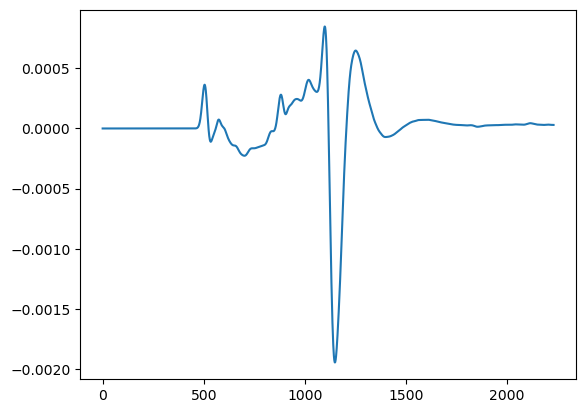

In [6]:
plt.plot(wavedata[0][0])
plt.show()

In [8]:
data.animation(np.array([6371000, 0, 0]), np.array([6371000, 0, 30]), channels=['UZ'])

Loading and interpolating:  18%|█▊        | 1000/5480 [00:10<00:44, 99.76point/s]


ValueError: shape mismatch: value array of shape (1000,3,200) could not be broadcast to indexing result of shape (1,1000,1,200)